In [1]:
# Do not run this cell on your machine if you don't know what it's for.
import jupyter_black
from sklearnex import patch_sklearn

patch_sklearn()
jupyter_black.load()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Adaboosting, Gradient Boosting, XGBoost Classifier

We will be working with a synthetic advertising data set, indicating whether or not a particular internet user clicked on an Advertisement on a company website. We will try to create a model that will predict whether or not they will click on an ad based off of the features of that user.

This data set contains the following features:

* `Daily Time Spent on Site`: consumer time on site in minutes
* `Age`: cutomer age in years
* `Area Income`: Avg. Income of geographical area of consumer
* `Daily Internet Usage`: Avg. minutes a day consumer is on the internet
* `Ad Topic Line`: Headline of the advertisement
* `City`: City of consumer
* `Male`: Whether or not consumer was male
* `Country`: Country of consumer
* `Timestamp`: Time at which consumer clicked on Ad or closed window
* `Clicked on Ad`: 0 or 1 indicated clicking on Ad

## Import Libraries

In [2]:
# !pip install xgboost==1.7.4
# conda install -c conda-forge xgboost

In [3]:
import xgboost as xgb

xgb.__version__

'1.7.4'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (7, 4)

In [5]:
df = pd.read_csv("advertising2.csv")
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


## Exploratory Data Analysis and Visualization

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
 9   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 78.3+ KB


In [7]:
df.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,65.000200,36.009000,55000.000080,180.000100,0.481000,0.50000
std,15.853615,8.785562,13414.634022,43.902339,0.499889,0.50025
min,32.600000,19.000000,13996.500000,104.780000,0.000000,0.00000
25%,51.360000,29.000000,47031.802500,138.830000,0.000000,0.00000
50%,68.215000,35.000000,57012.300000,183.130000,0.000000,0.50000
75%,78.547500,42.000000,65470.635000,218.792500,1.000000,1.00000
max,91.430000,61.000000,79484.800000,269.960000,1.000000,1.00000


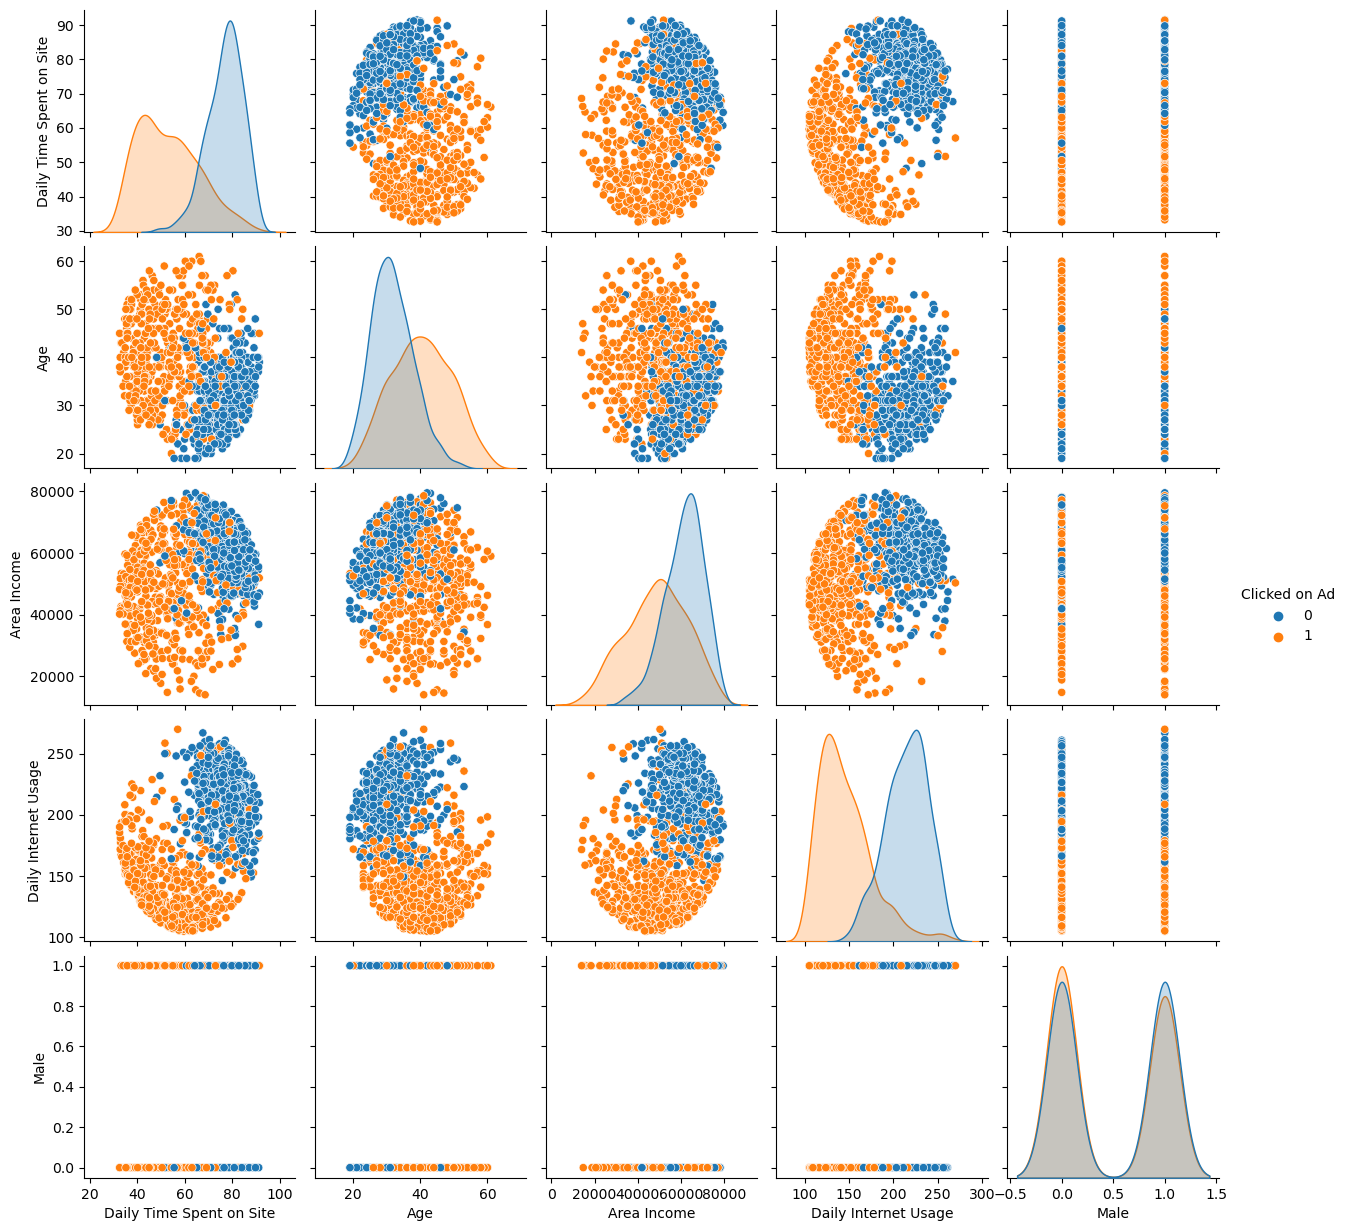

In [8]:
sns.pairplot(df, hue="Clicked on Ad")
plt.show()

## Train | Test Split

In [9]:
for feature in df.select_dtypes("object").columns:
    print(feature, df[feature].nunique())

# We are checking the number of unique categories in each categorical variable of data type `object`.
# We will drop features that contain many unique categorical observations (high cardinality)
# Tree-based models can assign too much weight to features that contain too many unique categories.
# Also, if a feature has too many unique categories and not enough observation points in them, the model will not learn enough about those categories.

Ad Topic Line 1000
City 969
Country 237
Timestamp 1000


In [10]:
from sklearn.model_selection import train_test_split

In [11]:
cat = df.select_dtypes("object").columns.tolist()
cat
# we first identify categorical features. We have already decided to drop them above.

['Ad Topic Line', 'City', 'Country', 'Timestamp']

In [12]:
cat2 = cat + ["Clicked on Ad"]
cat2

# We will add our target to the fetures we will drop and then drop it from X.

['Ad Topic Line', 'City', 'Country', 'Timestamp', 'Clicked on Ad']

In [13]:
X = df.drop(columns=cat2)
y = df["Clicked on Ad"]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

In [15]:
X_train.head(1)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male
716,39.96,35,53898.89,138.52,1


## Modelling and Model Performance

In [16]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# The default base estimator of AdaBoostClassifier is DecisionTreeClassifier.
# We are importing DecisionTreeClassifier as well to show how we can tweak its hyperparameters.

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
)
from sklearn.model_selection import cross_validate

In [17]:
def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)

    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

In [18]:
# base_estimator = DecisionTreeClassifier(max_depth=1)

ada_model = AdaBoostClassifier(n_estimators=50, random_state=42)

```python
Ada_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, random_state=42)
```

If we don't get good results with adaboost's default parameters, we can play with base_estimator's hyperparameters like here. Since adaboost algorithm relies on weak learners, try not to set max_depth to more than 2. Deeper trees are not really weak learners.

In [19]:
ada_model.fit(X_train, y_train)

AdaBoostClassifier(random_state=42)

In [20]:
eval_metric(ada_model, X_train, y_train, X_test, y_test)

# no overfitting. we will confirm with CV.

Test_Set
[[41  3]
 [ 4 52]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        44
           1       0.95      0.93      0.94        56

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100


Train_Set
[[454   2]
 [ 12 432]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       456
           1       1.00      0.97      0.98       444

    accuracy                           0.98       900
   macro avg       0.98      0.98      0.98       900
weighted avg       0.98      0.98      0.98       900



In [21]:
model = AdaBoostClassifier(n_estimators=50, random_state=42)

scores = cross_validate(
    model,
    X_train,
    y_train,
    scoring=["accuracy", "precision", "recall", "f1"],
    cv=10,
    return_train_score=True,
)
df_scores = pd.DataFrame(scores, index=range(1, 11))
df_scores.mean()[2:]

# no overfitting.

test_accuracy      0.961111
train_accuracy     0.985802
test_precision     0.968795
train_precision    0.996678
test_recall        0.952727
train_recall       0.974471
test_f1            0.960164
train_f1           0.985440
dtype: float64

## Tree Visualization

In [22]:
from sklearn.tree import plot_tree

In [23]:
model = AdaBoostClassifier(n_estimators=3, random_state=42)
model.fit(X_train, y_train)

# we will only visualize 3 trees and briefly talk about the logic.

AdaBoostClassifier(n_estimators=3, random_state=42)

In [24]:
# targets = df["Clicked on Ad"].astype("str")

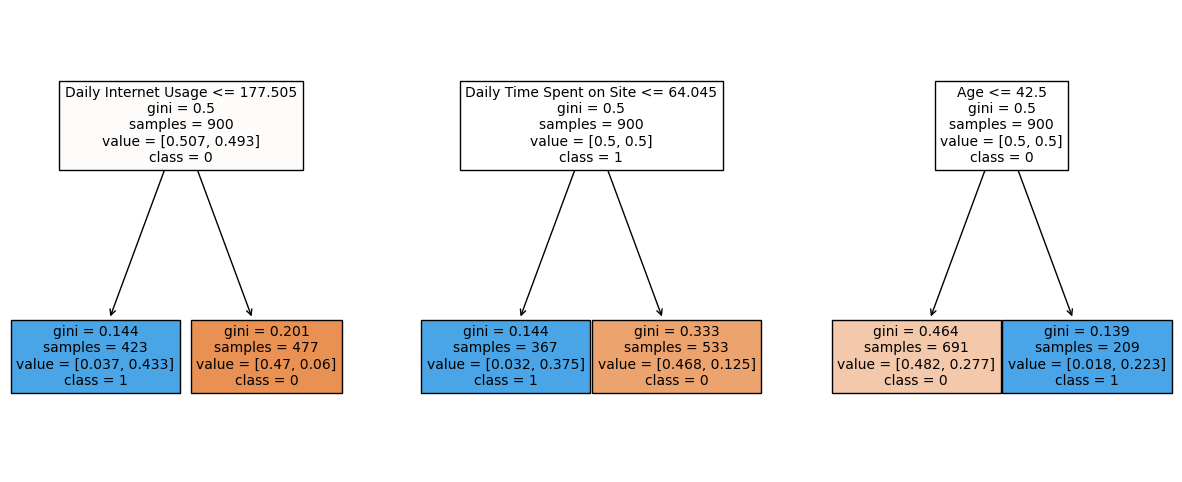

In [25]:
# features = list(X.columns)
targets = df["Clicked on Ad"].astype("str")
plt.figure(figsize=(15, 6), dpi=100)
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plot_tree(
        model.estimators_[i],
        filled=True,
        feature_names=X.columns.tolist(),
        class_names=targets.unique().tolist(),
        fontsize=10,
    );

# We need to convert the targets to strings. Otherwise you will get an error.

# Now let's try to classify the following observation point manually, using the trees shown down below.

# Daily Time Spent on Site 68.95
# Age 35.00
# Area Income 61833.90
# Daily Internet Usage 156.09
# Male 0.00

# 1st tree predicted class 1. The weight coefficient of the tree is 1.117
# 2nd tree predicted 0. The weight coefficient of the tree is 0.841
# 3rd tree predicted 0. The weight coefficient of the tree is 0.434


# Total weight of the tree(s) that predicted 0:
# weight totals = 0.8418 + 0.4349 = 1.2767

# Total weight of tree(s) that predicted 1: 1.1174

# Since the total weight of tree(s) predicting class 0 is greater than the total weight of tree(s)
# predicting class 1, our model will classify the observation we gave to the model above as class 0.

## Gridsearch

In [26]:
from sklearn.model_selection import GridSearchCV

In [27]:
model = AdaBoostClassifier(random_state=42)

In [28]:
param_grid = {
    "n_estimators": [20, 30, 50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2, 0.5, 1.0],
}

# There is always a trade off between the number of trees (n_estimators) and the learning rate.

In [29]:
ada_grid_model = GridSearchCV(
    model, param_grid, cv=5, scoring="f1", return_train_score=True
)

In [30]:
ada_grid_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=42),
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0],
                         'n_estimators': [20, 30, 50, 100, 200]},
             return_train_score=True, scoring='f1')

In [31]:
ada_grid_model.best_estimator_

AdaBoostClassifier(learning_rate=0.1, n_estimators=100, random_state=42)

In [32]:
pd.DataFrame(ada_grid_model.cv_results_).loc[
    ada_grid_model.best_index_, ["mean_test_score", "mean_train_score"]
]

mean_test_score     0.969132
mean_train_score    0.975079
Name: 8, dtype: object

In [33]:
y_pred = ada_grid_model.predict(X_test)
y_pred_proba = ada_grid_model.predict_proba(X_test)

ada_f1 = f1_score(y_test, y_pred)
ada_recall = recall_score(y_test, y_pred)
ada_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
eval_metric(ada_grid_model, X_train, y_train, X_test, y_test)

Test_Set
[[40  4]
 [ 3 53]]
              precision    recall  f1-score   support

           0       0.93      0.91      0.92        44
           1       0.93      0.95      0.94        56

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100


Train_Set
[[453   3]
 [ 18 426]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       456
           1       0.99      0.96      0.98       444

    accuracy                           0.98       900
   macro avg       0.98      0.98      0.98       900
weighted avg       0.98      0.98      0.98       900



## Feature_importances

In [34]:
model = AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)
model.feature_importances_

feats = pd.DataFrame(
    index=X.columns, data=model.feature_importances_, columns=["ada_importance"]
)
ada_imp_feats = feats.sort_values("ada_importance", ascending=False)
ada_imp_feats

,ada_importance
Daily Internet Usage,0.29
Daily Time Spent on Site,0.28
Age,0.22
Area Income,0.21
Male,0.00


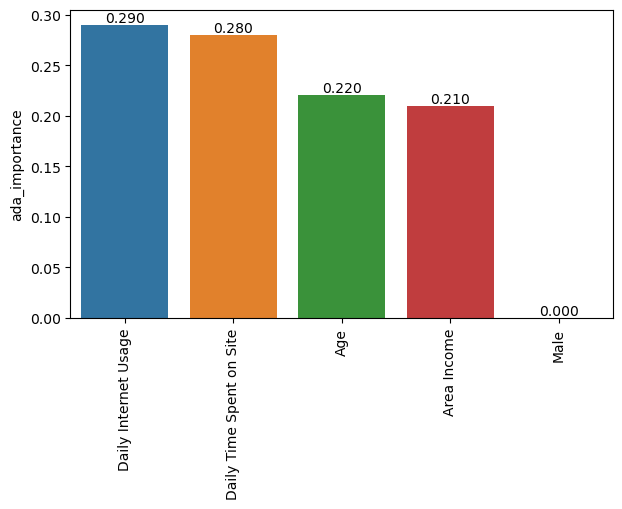

In [35]:
# plt.figure(figsize=(12,6))
ax = sns.barplot(data=ada_imp_feats, x=ada_imp_feats.index, y="ada_importance")
ax.bar_label(ax.containers[0], fmt="%.3f")
plt.xticks(rotation=90);

## Evaluating ROC Curves and AUC

In [36]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay

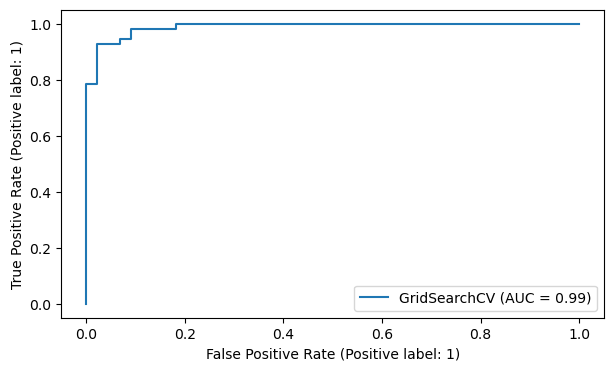

In [37]:
RocCurveDisplay.from_estimator(ada_grid_model, X_test, y_test);

## Gradient Boosting Modelling and Model Performance

In [38]:
# It is a tree-based model that uses gradient descent algorithm to optimize errors.
# Each observation is initialized with a fixed probability. If there are more observations from the positive class in the data,
# the probability is greater than 0.5.
# If there are more observations from the negative class, the probability is less than 0.5. By subtracting this probability value
# from the 1 and 0 probability values, we find the residual values. The model tries to perfect its estimates
# by bringing these residual values closer to 0.

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

In [40]:
grad_model = GradientBoostingClassifier(random_state=42)

# unlike random forest:
# 1. It is set to max_dept=3 by default in order to be a weak learner.

# 2. How much each tree will contribute to the prediction is arranged with the learning rate hyper parameter.
# default is 0.1.

# 3. Since gradient descent-based model is used in the background, there is a loss hyper parameter in classification.
# And by default it is log_loss. It tries to minimize residuals with the gradient boosting log_loss function.

# 4. Friedman_mse, which is calculated in a similar way to mse, is used as the branching criterion (criterion) of leaves.
# They are essentially regression trees. They are trying to predict the pseudo-residuals (negative gradients of the loss).

# 5. With the subsample, it is determined how much of the dataset will be used in each tree. If we make sub_sample=0.8,
# it uses 0.8 observations randomly selected from the train data in each tree. This process is repeated for each tree.
# helps to avoid overfitting.

# 6. Most other hyperparameters are the same or similar to random forest.

# The trade off between the number of trees or the learning rate should be well adjusted. Otherwise it goes to overfiting.

In [41]:
grad_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [42]:
eval_metric(grad_model, X_train, y_train, X_test, y_test)

Test_Set
[[41  3]
 [ 2 54]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        44
           1       0.95      0.96      0.96        56

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100


Train_Set
[[456   0]
 [  1 443]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       456
           1       1.00      1.00      1.00       444

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



In [43]:
model = GradientBoostingClassifier(random_state=42)

scores = cross_validate(
    model,
    X_train,
    y_train,
    scoring=["accuracy", "precision", "recall", "f1", "roc_auc"],
    cv=10,
    return_train_score=True,
)
df_scores = pd.DataFrame(scores, index=range(1, 11))
df_scores.mean()[2:]

test_accuracy      0.952222
train_accuracy     0.999012
test_precision     0.958870
train_precision    1.000000
test_recall        0.945960
train_recall       0.997997
test_f1            0.951603
train_f1           0.998997
test_roc_auc       0.987972
train_roc_auc      0.999994
dtype: float64

## Gridsearch

In [44]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "subsample": [0.5, 1],
    "max_features": [None, 2, 3, 4],
    "learning_rate": [0.001, 0.01, 0.1],
    "max_depth": [3, 4, 5, 6],
}  # 0.8

In [45]:
gb_model = GradientBoostingClassifier(random_state=42)

In [46]:
grid = GridSearchCV(
    gb_model, param_grid, scoring="f1", verbose=2, n_jobs=-1, return_train_score=True
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] END learning_rate=0.001, max_depth=3, max_features=None, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END learning_rate=0.001, max_depth=3, max_features=None, n_estimators=200, subsample=1; total time=   0.3s
[CV] END learning_rate=0.001, max_depth=3, max_features=2, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END learning_rate=0.001, max_depth=3, max_features=2, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=3, max_features=2, n_estimators=300, subsample=0.5; total time=   0.3s
[CV] END learning_rate=0.001, max_depth=3, max_features=3, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=3, max_features=4, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END learning_rate=0.001, max_depth=3, max_features=4, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=3, m

GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 4, 5, 6],
                         'max_features': [None, 2, 3, 4],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.5, 1]},
             return_train_score=True, scoring='f1', verbose=2)

In [47]:
grid.best_estimator_

GradientBoostingClassifier(max_features=3, random_state=42, subsample=0.5)

In [48]:
pd.DataFrame(grid.cv_results_).loc[
    grid.best_index_, ["mean_test_score", "mean_train_score"]
]

mean_test_score     0.965834
mean_train_score    0.995479
Name: 204, dtype: object

In [49]:
y_pred = grid.predict(X_test)
y_pred_proba = grid.predict_proba(X_test)

gb_f1 = f1_score(y_test, y_pred)
gb_recall = recall_score(y_test, y_pred)
gb_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

eval_metric(grid, X_train, y_train, X_test, y_test)

Test_Set
[[42  2]
 [ 2 54]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        44
           1       0.96      0.96      0.96        56

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100


Train_Set
[[456   0]
 [  4 440]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       456
           1       1.00      0.99      1.00       444

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



## Feature importances

In [50]:
model = GradientBoostingClassifier(
    max_features=3, n_estimators=100, subsample=0.5, random_state=42
)
model.fit(X_train, y_train)

model.feature_importances_

feats = pd.DataFrame(
    index=X.columns, data=model.feature_importances_, columns=["grad_importance"]
)
grad_imp_feats = feats.sort_values("grad_importance", ascending=False)
grad_imp_feats

,grad_importance
Daily Internet Usage,0.551346
Daily Time Spent on Site,0.319058
Area Income,0.074586
Age,0.053003
Male,0.002008


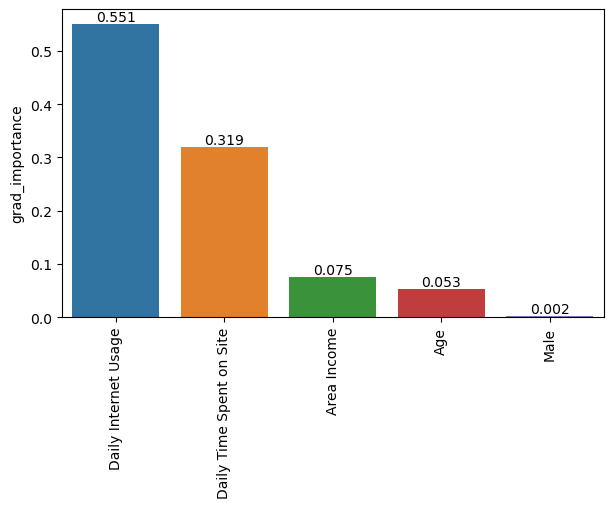

In [51]:
# plt.figure(figsize=(12,6))
ax = sns.barplot(data=grad_imp_feats, x=grad_imp_feats.index, y="grad_importance")
ax.bar_label(ax.containers[0], fmt="%.3f")
plt.xticks(rotation=90);

## Evaluating ROC Curves and AUC

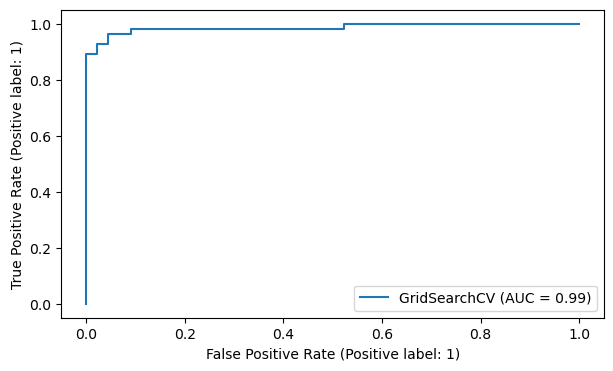

In [52]:
RocCurveDisplay.from_estimator(grid, X_test, y_test);

## XG Boosting Modelling and Model Performance

In [53]:
from xgboost import XGBClassifier

In [54]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [55]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

# Hyper_parameters:
# The initial prediction score of all instances, global bias
# The parameter is automatically estimated for selected objectives before training. To disable the estimation, specify a real number argument.
# For sufficient number of iterations, changing this value will not have too much effect.
# The model starts all observations at the default probability and
# tries to increase this value to probability 1.0 for the class 1 and decrease is to 0.0 for the class 0.

# max_depth=6 is the default value of learning_rate=0.300000012. These are some of the parameters
# that have the most impact on overfiting.

# subsample=1 by default uses all observations in all trees. Values around 0.8 should be tried to prevent overifting.
# subsumple=0.8 means randomly pick 80% of observations from train set on all trees and use them on trees.
# Random selection is made again for each tree. This process increases randomness.

# colsample_bytree=1 defaults to 1. It determines the number of features that should be used for each tree.
# If our data consists of 20 features and colsample_bytree=0.5, it will only use 10 randomly selected features
# from 20 featuras for each tree. used to increase randomness. Subsampling occurs once for every tree constructed.

# colsample_bylevel=1 defaults to 1. If colsample_bylevel=0.5, 5 features randomly selected from among the features
# (10 features) to be used for each tree are used for each level. is the subsample ratio of columns for each level.
# Subsampling occurs once for every new depth level reached in a tree.
# Columns are subsampled from the set of columns chosen for the current tree.

# gamma=0 default is 0. Ranges between [0, +inf]
# Minimum loss reduction required to make a further partition on a leaf node of the tree.
# The larger gamma is, the more conservative the algorithm will be.

# min_child_weight=1 default is 1. Ranges [0, +inf]
# Minimum sum of instance weight (hessian) needed in a child.
# If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight,
# then the building process will give up further partitioning.
# In linear regression task, this simply corresponds to minimum number of instances needed to be in each node.
# The larger min_child_weight is, the more conservative the algorithm will be.

# scale_pos_weight=1 is the weighting parameter. However, it is only used for binary data.
# If the ratio of classes is 1/10, this parameter should be set to 10 to increase the weight of the minority class.
# A typical value to consider: sum(negative instances) / sum(positive instances)

# alpha [default=0, alias: reg_alpha]:
# L1 regularization term on weights. Increasing this value will make model more conservative. Normalised to number of training examples.

# lambda [default=1, alias: reg_lambda]:
# L2 regularization term on weights. Increasing this value will make model more conservative.

# It does not use metrics such as gini, entropy or mse for the branches in each tree,
# instead it uses a parameter called similarity score, in which the regularization parameter is used in the calculation.

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [56]:
eval_metric(xgb, X_train, y_train, X_test, y_test)

Test_Set
[[40  4]
 [ 3 53]]
              precision    recall  f1-score   support

           0       0.93      0.91      0.92        44
           1       0.93      0.95      0.94        56

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100


Train_Set
[[456   0]
 [  0 444]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       456
           1       1.00      1.00      1.00       444

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



In [57]:
model = XGBClassifier(random_state=42)

scores = cross_validate(
    model,
    X_train,
    y_train,
    scoring=["accuracy", "precision", "recall", "f1", "roc_auc"],
    cv=10,
    return_train_score=True,
)
df_scores = pd.DataFrame(scores, index=range(1, 11))
df_scores.mean()[2:]

test_accuracy      0.956667
train_accuracy     1.000000
test_precision     0.966827
train_precision    1.000000
test_recall        0.945859
train_recall       1.000000
test_f1            0.955630
train_f1           1.000000
test_roc_auc       0.988984
train_roc_auc      1.000000
dtype: float64

## Gridsearch

In [58]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.1, 0.2],
    "subsample": [0.5, 0.8, 1],
    "colsample_bytree": [0.5, 0.7, 1],
}

In [59]:
xgb_model = XGBClassifier(random_state=42)  # default random_state=42

In [60]:
xgb_grid = GridSearchCV(
    xgb_model, param_grid, scoring="f1", verbose=2, n_jobs=-1, return_train_score=True
)

xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END learning_rate=0.1, max_depth=4, max_features=None, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=4, max_features=None, n_estimators=300, subsample=1; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=4, max_features=2, n_estimators=300, subsample=1; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=4, max_features=3, n_estimators=300, subsample=1; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=4, max_features=4, n_estimators=200, subsample=1; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=None, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, max_features=None, n_estimators=200, subsample=0.5; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, max_features=None, n_estimators=300, subsample=1; total time=   0.6s
[CV] END learning_rate=0.1, max_depth=5, max_features=3, n_e

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.7, 1],
                         'learning_rate': [0.1, 0.2], 'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.5, 0.8, 1]},
             return_train_score=True, scoring='f1', verbose=2)

In [61]:
xgb_grid.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.2,
 'max_depth': 3,
 'n_estimators': 50,
 'subsample': 0.8}

In [62]:
xgb_grid.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [63]:
pd.DataFrame(xgb_grid.cv_results_).loc[
    xgb_grid.best_index_, ["mean_test_score", "mean_train_score"]
]

mean_test_score     0.969414
mean_train_score    0.985791
Name: 28, dtype: object

In [64]:
y_pred = xgb_grid.predict(X_test)
y_pred_proba = xgb_grid.predict_proba(X_test)

xgb_f1 = f1_score(y_test, y_pred)
xgb_recall = recall_score(y_test, y_pred)
xgb_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

eval_metric(xgb_grid, X_train, y_train, X_test, y_test)

Test_Set
[[40  4]
 [ 4 52]]
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        44
           1       0.93      0.93      0.93        56

    accuracy                           0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.92      0.92      0.92       100


Train_Set
[[454   2]
 [ 11 433]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       456
           1       1.00      0.98      0.99       444

    accuracy                           0.99       900
   macro avg       0.99      0.99      0.99       900
weighted avg       0.99      0.99      0.99       900



## Feature importances

In [65]:
model = XGBClassifier(
    n_estimators=50, colsample_bytree=0.7, subsample=0.8, learning_rate=0.1, max_depth=3
)
model.fit(X_train, y_train)

model.feature_importances_

feats = pd.DataFrame(
    index=X.columns, data=model.feature_importances_, columns=["xgb_importance"]
)
xgb_imp_feats = feats.sort_values("xgb_importance", ascending=False)
xgb_imp_feats

,xgb_importance
Daily Internet Usage,0.399013
Daily Time Spent on Site,0.341119
Area Income,0.136597
Age,0.114437
Male,0.008833


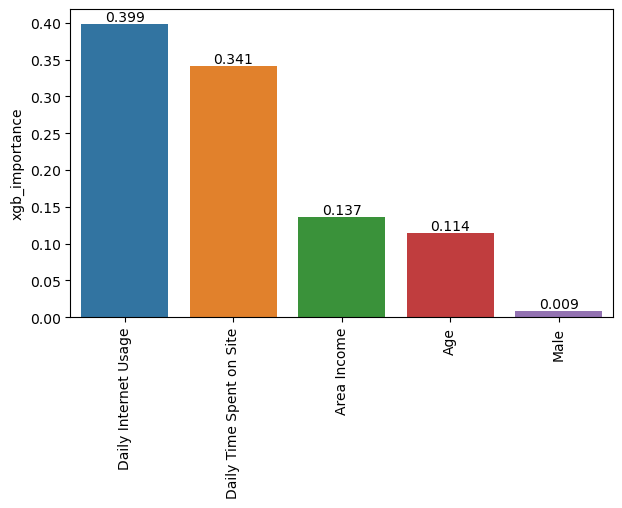

In [66]:
ax = sns.barplot(data=xgb_imp_feats, x=xgb_imp_feats.index, y="xgb_importance")
ax.bar_label(ax.containers[0], fmt="%.3f")
plt.xticks(rotation=90);

## Feature importance comparison

In [67]:
pd.concat([ada_imp_feats, grad_imp_feats, xgb_imp_feats], axis=1)

,ada_importance,grad_importance,xgb_importance
Daily Internet Usage,0.29,0.551346,0.399013
Daily Time Spent on Site,0.28,0.319058,0.341119
Age,0.22,0.053003,0.114437
Area Income,0.21,0.074586,0.136597
Male,0.00,0.002008,0.008833


## Evaluating ROC Curves and AUC

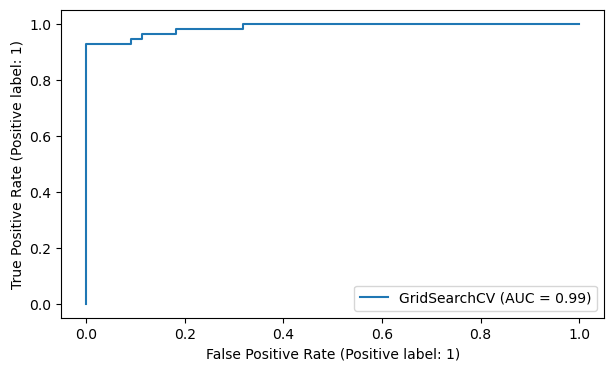

In [68]:
RocCurveDisplay.from_estimator(xgb_grid, X_test, y_test);

## Comparing Models

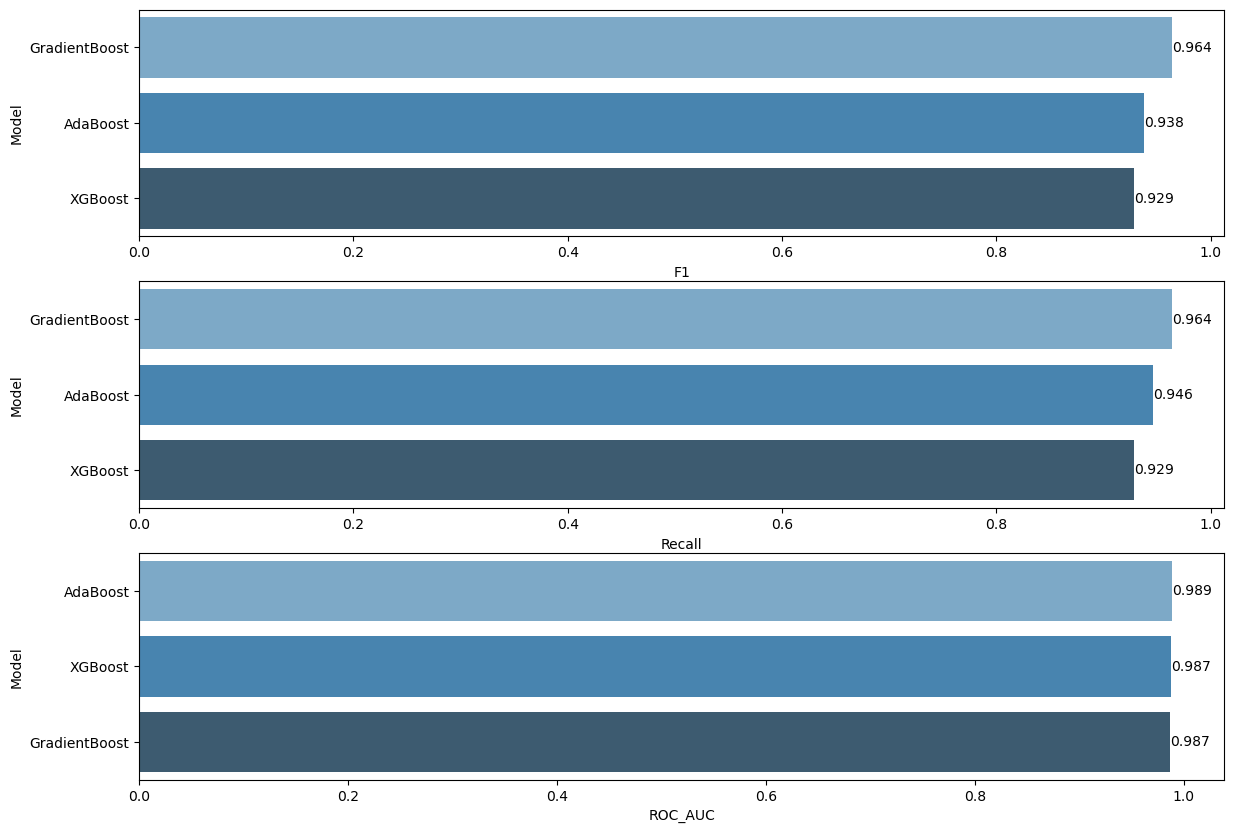

In [69]:
compare = pd.DataFrame(
    {
        "Model": ["AdaBoost", "GradientBoost", "XGBoost"],
        "F1": [ada_f1, gb_f1, xgb_f1],
        "Recall": [ada_recall, gb_recall, xgb_recall],
        "ROC_AUC": [ada_auc, gb_auc, xgb_auc],
    }
)


plt.figure(figsize=(14, 10))

plt.subplot(311)
compare = compare.sort_values(by="F1", ascending=False)
ax = sns.barplot(x="F1", y="Model", data=compare, palette="Blues_d")
ax.bar_label(ax.containers[0], fmt="%.3f")

plt.subplot(312)
compare = compare.sort_values(by="Recall", ascending=False)
ax = sns.barplot(x="Recall", y="Model", data=compare, palette="Blues_d")
ax.bar_label(ax.containers[0], fmt="%.3f")

plt.subplot(313)
compare = compare.sort_values(by="ROC_AUC", ascending=False)
ax = sns.barplot(x="ROC_AUC", y="Model", data=compare, palette="Blues_d")
ax.bar_label(ax.containers[0], fmt="%.3f")
plt.show()

### Changelog
Wed 19, 2023
1. Updated `plot_tree parameters to use lists instead of arrays for feature names and classes (otherwise it throws an error).
2. Removed the explanation regarding how "resampling" results in duplicating data points that are difficult to classify correctly. In `sklearn`, there's no such implementation. `sklearn` uses `sample_weights` for this.
3. Removed GradientBoosting calculations.
4. Updated XGBoost hyperparameter explanations.